In [1]:
import warnings
import json

from pandas.io.json import json_normalize

warnings.filterwarnings(action='ignore')
import pandas as pd  # 데이터 분석을 위한 전처리를 위해 import 한다.
import matplotlib as mpl  # matplolib에서 음수 데이터의 '-'부호가 깨지는 것을 방지하기위해 import 한다.

mpl.rcParams['axes.unicode_minus'] = False  # matplolib에서 음수 데이터의 '-'부호가 깨지는 것을 방지한다.
import matplotlib.pyplot as plt  # 시각화를 하기 위해 import 한다.
import seaborn as sns

import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams["font.size"] = 10  # matplolib에서 사용할 글꼴 크기 설정
plt.rcParams["font.family"] = "NanumGothicCoding"  # matplolib에서 사용할 글꼴 설정

pd.options.display.float_format = '{:,.5f}'.format

In [2]:
rank = pd.read_csv('data/rank.csv')
rank_final = pd.read_csv('data/rank_final - changed.csv')

In [3]:
characterNamesEn = pd.read_csv('data/characterList - origin.csv')  # 캐릭터 영문명
characterNamesKr = pd.read_csv('data/characterList - changed.csv')  # 캐릭터 한글명
skinNames = pd.read_csv('data/skin - changed.csv')  # 스킨
weaponNames = pd.read_csv('data/weapon - changed.csv')  # 무기
armorNames = pd.read_csv('data/armor - changed.csv')  # 방어구
# 무기별 사용캐릭터 추가
weapon = pd.DataFrame({'num': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25],
                       'name': ["글러브", "톤파", "방망이", "채찍", "투척", "암기", "활", "석궁", "권총", "돌격소총", "저격총", "망치", "도끼", "단검",
                                "양손검", "쌍검", "창", "쌍절곤", "레이피어", "기타", "카메라", "아르카나", "VF의수"],
                       'character': [['현우', '레온', '얀', '니키', '리다이린'], ['현우', '레온', '얀', '아이작', '알렉스'],
                                     ['바바라', '매그너스', '루크', '띠아'], ['레녹스', '마이', '라우라'],
                                     ['시셀라', '이바', '이렘', '아드리아나', '윌리엄', '자히르', '셀린'],
                                     ['시셀라', '엠마', '자히르', '타지아', '클로에', '혜진', '알렉스'],
                                     ['리오', '나딘', '혜진'], ['나딘', '칼라'], ['아야', '로지', '제니', '아이솔', '실비아', '알렉스'],
                                     ['아야', '아이솔', '헤이즈'],
                                     ['아야', '버니스', '테오도르'], ['매그너스', '수아', '일레븐'], ['재키', '마커스', '에스텔'],
                                     ['재키', '쇼이치', '캐시', '다니엘', '쇼우'],
                                     ['재키', '유키', '피오라', '에이든', '알렉스'], ['재키', '카밀로', '유키', '캐시'], ['쇼우', '펠릭스', '피오라'],
                                     ['리다이린', '피올로'],
                                     ['피오라', '키아라', '카밀로', '아델라', '엘레나'], ['하트', '프리야'], ['나타폰', '마르티나'],
                                     ['요한', '비앙카', '엠마', '아디나'], ['에키온']]})

In [4]:

characterList = pd.DataFrame()

for i in range(len(rank_final.nameW.value_counts())):
    gg = f'{"{"}"nameW" : "{rank_final.nameW.value_counts().index[i]}","code" : {rank_final[rank_final.nameW == rank_final.nameW.value_counts().index[i]].characterNum.values[0]}{"}"}'

    characterList = pd.concat([characterList, json_normalize(json.loads(gg))], ignore_index=True)
characterList = characterList.sort_values('code')
characterList = characterList.reset_index(drop=True)
# characterList

In [5]:

# 62개 캐릭터의 핵심 정보

df_code = pd.DataFrame()
df_characterStats = pd.DataFrame()

for i in range(84):
    character = pd.concat([df_code, rank_final[rank_final.nameW == characterList.nameW[i]]])
    stat = (
        # 실험체 이름
        f'{"{"}"characterName" : "{characterList.nameW[i]}", '
        # 실험체 번호
        f'"characterCode" : {characterList.code[i]}, '
        # 가장 많이 사용한 스킨, 사용 횟수
        f'"mostSkin" : "{skinNames[skinNames.code == int(character.skinCode.value_counts().head(1).index[0])].values[0][0]}", "mostSkinCount" : {character.skinCode.value_counts().head(1).values[0]}, '

        # 무기(이대로 사용하면 가장 많이 사용한 무기로 나머지 무기도 통합됨)
        f'"characterWeapon" : "{weapon[weapon.num == character.bestWeapon.values[0]].name.values[0]}",'

        # 여기부터 마지막까지 아래와 같은 리스트형식으로 무기별 분류 필요
        #  ([ {무기군1: 킬수}, {무기군2 : 킬수} ...])
        #  ([ {무기군1: 루트무기}, {무기군2 : 루트무기} ...] )

        # 평균 플레이어 킬수
        f'"averageKillPlayer" : {character.playerKill.mean():.2f}, '
        # 평균 플레이어 데미지
        f'"averageDamegeToPlayer" : {character.damageToPlayer.mean():.2f}, '
        # 평균 야동 킬수
        f'"averageKillMonster" : {character.monsterKill.mean():.2f}, '
        # 평균 야동 데미지
        f'"averageDamegeToMonster" : {character.damageToMonster.mean():.2f}, '
        # 게임 플레이 수
        f'"totalGames" : {character.count()[0]}, '
        # # 평균 승률 => 자히르 투척 승률 0%짜리 터짐
        f'"winRate" : {character[character.victory == 1].victory.count() / character.victory.count():.2f}, '

        # 평균 등수
        f'"averageRank" : {character[character.escapeState != 3].gameRank.mean():.2f}, '
        # 탈출 횟수
        f'"escapeCount" : {character[character.escapeState == 3].escapeState.count()}, '
        # 평균 mmr 획득률
        f'"averageMMR" : {character.mmrGain.mean():.2f}, '
        # 픽률
        f'"pickRate" : {character.count()[0] / 19248 * 100:.2f},'


        # 최종 아이템, 사용 횟수
        f'"finalWeapon" : "{weaponNames[weaponNames.code == int(character["equipment.0"].value_counts().head(1).index[0])].values[0][1]}", "finalWeaponCount" : {character["equipment.0"].value_counts().head(1).values[0]}, '
        f'"finalBody" : "{armorNames[armorNames.code == int(character["equipment.1"].value_counts().head(1).index[0])].values[0][1]}", "finalBodyCount" : {character["equipment.1"].value_counts().head(1).values[0]}, '
        f'"finalHead" : "{armorNames[armorNames.code == int(character["equipment.2"].value_counts().head(1).index[0])].values[0][1]}", "finalHeadCount" : {character["equipment.2"].value_counts().head(1).values[0]}, '
        f'"finalArm" : "{armorNames[armorNames.code == int(character["equipment.3"].value_counts().head(1).index[0])].values[0][1]}", "finalArmCount" : {character["equipment.3"].value_counts().head(1).values[0]}, '
        f'"finalFoot" : "{armorNames[armorNames.code == int(character["equipment.4"].value_counts().head(1).index[0])].values[0][1]}", "finalFootCount" : {character["equipment.4"].value_counts().head(1).values[0]}, '
        f'"finalTinkled" : "{armorNames[armorNames.code == int(character["equipment.5"].value_counts().head(1).index[0])].values[0][1]}", "finalTinkledCount" : {character["equipment.5"].value_counts().head(1).values[0]}, '

        # 가장 많이 선택한 루트 아이템, 사용 횟수
        f'"routeWeapon" : "{weaponNames[weaponNames.code == int(character["equipFirstItemForLog.0"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeWeaponCount" : {character["equipFirstItemForLog.0"].value_counts().head(1)[0]}, '
        f'"routeBody" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.1"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeBodyCount" : {character["equipFirstItemForLog.1"].value_counts().head(1)[0]}, '
        f'"routeHead" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.2"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeHeadCount" : {character["equipFirstItemForLog.2"].value_counts().head(1)[0]}, '
        f'"routeArm" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.3"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeArmCount" : {character["equipFirstItemForLog.3"].value_counts().head(1)[0]}, '
        f'"routeFoot" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.4"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeFootCount" : {character["equipFirstItemForLog.4"].value_counts().head(1)[0]}, '

        f'"routeTinkled" : "", "routeTinkledCount" : ""{"}"}'
    )
    df_characterStats = pd.concat([df_characterStats, json_normalize(json.loads(stat))], ignore_index=True)
    del character, stat
# df_characterStats


In [6]:
df_characterStats.characterName[45] = '알렉스'
# print(df_characterStats.characterName[45])
characterList.nameW[45] = '알렉스'
# print(characterList.nameW[45])

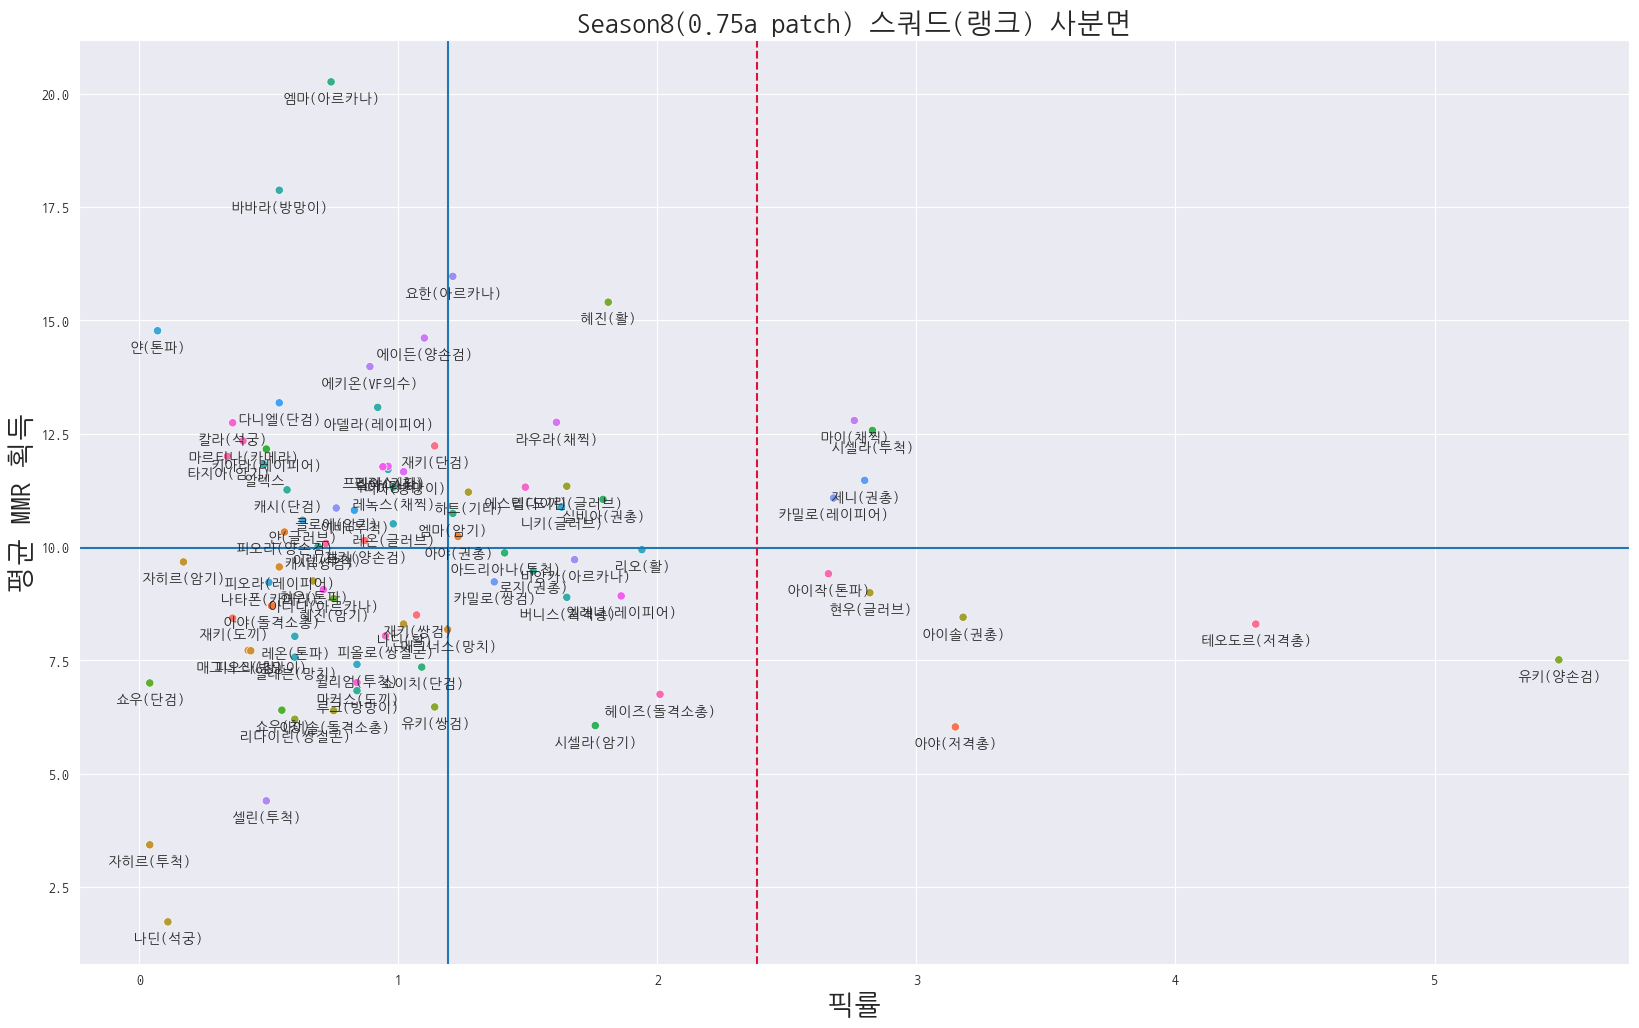

In [7]:
mmr = df_characterStats.averageMMR.mean()
pick = df_characterStats.pickRate.mean()
xy = pd.DataFrame()
for i, char in df_characterStats.iterrows():
    xy = pd.concat([xy, json_normalize(json.loads(
        f'{"{"}"characterCode" : {characterList[characterList.nameW == char.characterName].code.values[0]} ,"characterName" : "{characterList[characterList.nameW == char.characterName].nameW.values[0]}" ,"pickRate" : {df_characterStats.totalGames[i] / 19247 * 100:.2f}, "mmrGain" : {df_characterStats.averageMMR[i]:.2f}{"}"}'))])

plt.figure(figsize=(20, 12))

plt.xlabel('픽률', fontsize=20)
plt.ylabel('평균 MMR 획득', fontsize=20)
# plt.scatter(xy.pickRate, xy.mmrGain)

sns.scatterplot(xy, x=xy.pickRate, y=xy.mmrGain, hue=xy.characterName, legend=False)
plt.title('Season8(0.75a patch) 스쿼드(랭크) 사분면', fontsize=20)
plt.axhline(mmr, 0, 1)
plt.axvline(pick, 0, 1)
plt.axvline(pick * 2, 0, 1, linestyle='--', color='crimson')
for _, j in xy.iterrows():
    plt.annotate(j.characterName,
                 (j.pickRate, j.mmrGain),
                 textcoords="offset points",  # 텍스트 위치를 (x,y)로 부터의 오프셋 (offset_x, offset_y)로 지정
                 xytext=(0, -15),  # (x, y)로 부터의 오프셋 (offset_x, offset_y)
                 ha='center')
plt.show()

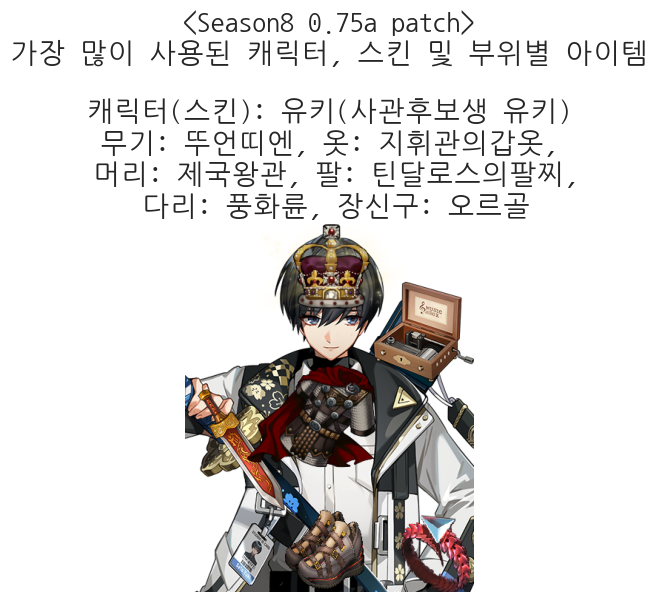

In [8]:
img = mpl.image.imread('data/mostItem/metaGolem-half.png')
plt.axis('off')
plt.title(f'<Season8 0.75a patch>\n'
          f'가장 많이 사용된 캐릭터, 스킨 및 부위별 아이템\n'
          f'\n캐릭터(스킨): {characterNamesKr[characterNamesKr.code == rank_final.characterNum.value_counts().head(1).index[0]].name.values[0]}({skinNames[skinNames.code == rank_final[rank_final.characterNum == rank_final.characterNum.value_counts().head(1).index[0]].skinCode.values[0]].values[0][0]})\n'
          f'무기: {weaponNames[weaponNames.code == int(rank_final["equipFirstItemForLog.0"].value_counts().head(1).index[0][1:-1])].name.values[0]}, 옷: {armorNames[armorNames.code == int(rank_final["equipFirstItemForLog.1"].value_counts().head(1).index[0][1:-1])].name.values[0]},\n 머리: {armorNames[armorNames.code == int(rank_final["equipFirstItemForLog.2"].value_counts().head(1).index[0][1:-1])].name.values[0]}, 팔: {armorNames[armorNames.code == int(rank_final["equipFirstItemForLog.3"].value_counts().head(1).index[0][1:-1])].name.values[0]},\n 다리: {armorNames[armorNames.code == int(rank_final["equipFirstItemForLog.4"].value_counts().head(1).index[0][1:-1])].name.values[0]}, '
          # 루트 장신구 api가 null이 뜨는 버그가 있어서 최종장신구로 대체
          f'장신구: {armorNames[armorNames.code == int(rank_final["equipment.5"].value_counts().head(1).index[0])].name.values[0]}',
          fontsize=20)
plt.imshow(img)
plt.show()

평균 MMR획득: 9.97, 평균 픽률: 1.19%
캐시(단검) 픽률: 0.57%, 승률: 0.21%, 평균 MMR획득: 11.26, 모스트 스킨: 사이키메딕 캐시
캐시(쌍검) 픽률: 0.69%, 승률: 0.32%, 평균 MMR획득: 10.01, 모스트 스킨: 사이키메딕 캐시


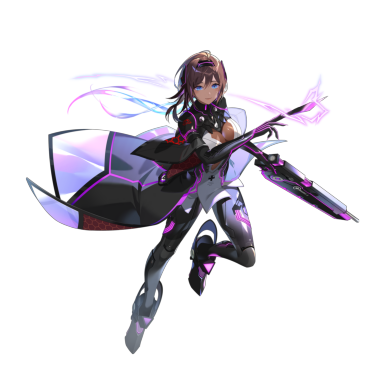

In [9]:
n = input()
img = mpl.image.imread(
    f'data/mostSkin/{df_characterStats[df_characterStats.characterCode == characterNamesKr[characterNamesKr.name == n].code.values[0]].mostSkin.value_counts().index[0]}/full.png')
plt.axis('off')
plt.imshow(img)
print(f'평균 MMR획득: {mmr:.2f}, 평균 픽률: {pick:.2f}%')
for _, c in df_characterStats.iterrows():
    if c.characterCode == characterNamesKr[characterNamesKr.name == n].values[0][0]:
        print(f'{c.characterName} 픽률: {c.pickRate}%, 승률: {c.winRate}%, 평균 MMR획득: {c.averageMMR}, 모스트 스킨: {c.mostSkin}')

캐시(단검) 픽률: 0.57%, 승률: 0.21%, 평균 MMR획득: 11.26, 모스트 스킨: 사이키메딕 캐시


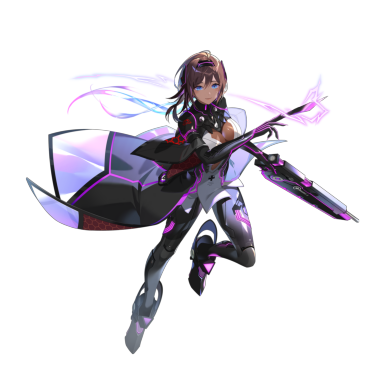

In [10]:
w = input()
skinList = pd.DataFrame()

skinList = pd.concat([skinList, df_characterStats[
    df_characterStats.characterCode == characterNamesKr[characterNamesKr.name == n].code.values[0]]], ignore_index=True)
gg = f'{n}({w})'
if n == '알렉스':
    gg = '알렉스'
    img = mpl.image.imread(
        f'data/mostSkin/{df_characterStats[df_characterStats.characterCode == characterNamesKr[characterNamesKr.name == n].code.values[0]].mostSkin.value_counts().index[0]}/full.png')
    plt.axis('off')
    plt.imshow(img)
    print('알렉스는 설정상 모든 무기를 다루지만 인게임에서는 밸런스 문제로 권총, 톤파, 암기, 양손검을 사용하는 실험체입니다.')
    print()
    print(f'평균 MMR획득: {mmr:.2f}, 평균 픽률: {pick:.2f}%')
    print(
        f'{df_characterStats[df_characterStats.characterName == gg].characterName.values[0]} 픽률: {df_characterStats[df_characterStats.characterName == gg].pickRate.values[0]}%, 승률: {df_characterStats[df_characterStats.characterName == gg].winRate.values[0]}%, 평균 MMR획득: {df_characterStats[df_characterStats.characterName == gg].averageMMR.values[0]}, 모스트 스킨: {df_characterStats[df_characterStats.characterName == gg].mostSkin.values[0]}')
elif w in skinList.characterWeapon.values:
    skin = skinList[skinList.characterName == f'{n}({w})'].mostSkin.values[0]
    img = mpl.image.imread(f'data/mostSkin/{skin}/full.png')
    plt.axis('off')
    plt.imshow(img)
    print(
        f'{df_characterStats[df_characterStats.characterName == gg].characterName.values[0]} 픽률: {df_characterStats[df_characterStats.characterName == gg].pickRate.values[0]}%, 승률: {df_characterStats[df_characterStats.characterName == gg].winRate.values[0]}%, 평균 MMR획득: {df_characterStats[df_characterStats.characterName == gg].averageMMR.values[0]}, 모스트 스킨: {df_characterStats[df_characterStats.characterName == gg].mostSkin.values[0]}')
else:
    print(f'{n}은 {w}를 사용하지 않는 실험체입니다.')

 특이사항
 크롤링하여 사용한 자료는 0.75 ~ 0.75a 패치 버전의 데이터이고 현재 패치 버전은 0.77이다.
 사용 아이템의 대부분이 스킬 증폭 아이템인걸 보면 평타 딜러보단 스킬딜러가 주도하는 메타임을 알 수 있다.

     뚜언띠엔: 방어력, 쿨타임 감소 무기
     지휘관의갑옷: 스킬 증폭 아이템, 제국왕관: 스킬 증폭 아이템, 틴달로스의팔찌: 스킬 증폭 아이템, 풍화륜: 스킬 증폭 아이템
     오르골: 공격 속도 아이템

 몇몇 캐릭은 스킨이 있음에도 불구하고 기본스킨이 가장 많이 쓰임(쇼우, 아델라, 윌리엄, 나타폰, 아디나, 피올로, 알렉스, 펠릭스)

     비인기 캐릭: 쇼우, 나타폰
     스킨이 기본일러만 못한 캐릭: 윌리엄, 알렉스
     원인 불명: 아디나, 아델라, 피올로, 펠릭스

 보통은 최신스킨이나 등급이 높은 스킨이 가장 많이 쓰이는데 유키의 경우는 초기 스킨인 사관후보생 유키가 가장 많이 쓰임


 앞으로의 패치 방향성 추측

     유키, 테오도르 => 정신나간 픽률은 너프 대상임을 추측 가능
     마이, 시셀라, 제니, 카밀로 => 평균 픽률의 2배 이상의 픽률과 평균 이상의 mmr 획득량은 너프 대상임을 추측 가능
     아이작, 현우, 아이솔, 아야 => mmr 획득량은 평균 이하지만 평균 픽률의 2배 이상의 픽률은 너프 대상임을 추측 가능

In [11]:
df2 = pd.DataFrame()
df_weaponStats = pd.DataFrame()

for i in range(23):
    test = pd.concat([df2, rank_final[rank_final.bestWeapon == weapon.num[i]]])
    stat = (
        f'{"{"}"weaponName" : "{weapon.name[i]}", '
        f'"characterCode" : {weapon.num[i]}, '
        # 평균 플레이어 킬수
        f'"averageKillPlayer" : {test.playerKill.mean():.2f}, '
        # 평균 플레이어 데미지
        f'"averageDamegeToPlayer" : {test.damageToPlayer.mean():.2f}, '
        # 평균 야동 킬수
        f'"averageKillMonster" : {test.monsterKill.mean():.2f}, '
        # 평균 야동 데미지
        f'"averageDamegeToMonster" : {test.damageToMonster.mean():.2f}, '
        # 게임 플레이 수
        f'"totalGames" : {test.count()[0]}, '
        # # 평균 승률 => 자히르 투척 승률 0%짜리 터짐
        f'"winRate" : {test[test.victory == 1].victory.count() / test.victory.count():.2f}, '

        # 평균 등수
        f'"averageRank" : {test[test.escapeState != 3].gameRank.mean():.2f}, '
        # 탈출 횟수
        f'"escapeCount" : {test[test.escapeState == 3].escapeState.count()}, '
        # 평균 mmr 획득률
        f'"averageMMR" : {test.mmrGain.mean():.2f}, '
        # 픽률
        f'"pickRate" : {test.count()[0] / 19248 * 100:.2f},'


        # 최종 아이템, 사용 횟수
        f'"finalWeapon" : "{weaponNames[weaponNames.code == int(test["equipment.0"].value_counts().head(1).index[0])].values[0][1]}", "finalWeaponCount" : {test["equipment.0"].value_counts().head(1).values[0]}, '
        f'"finalBody" : "{armorNames[armorNames.code == int(test["equipment.1"].value_counts().head(1).index[0])].values[0][1]}", "finalBodyCount" : {test["equipment.1"].value_counts().head(1).values[0]}, '
        f'"finalHead" : "{armorNames[armorNames.code == int(test["equipment.2"].value_counts().head(1).index[0])].values[0][1]}", "finalHeadCount" : {test["equipment.2"].value_counts().head(1).values[0]}, '
        f'"finalArm" : "{armorNames[armorNames.code == int(test["equipment.3"].value_counts().head(1).index[0])].values[0][1]}", "finalArmCount" : {test["equipment.3"].value_counts().head(1).values[0]}, '
        f'"finalFoot" : "{armorNames[armorNames.code == int(test["equipment.4"].value_counts().head(1).index[0])].values[0][1]}", "finalFootCount" : {test["equipment.4"].value_counts().head(1).values[0]}, '
        f'"finalTinkled" : "{armorNames[armorNames.code == int(test["equipment.5"].value_counts().head(1).index[0])].values[0][1]}", "finalTinkledCount" : {test["equipment.5"].value_counts().head(1).values[0]}, '

        # 가장 많이 선택한 루트 아이템, 사용 횟수
        f'"routeWeapon" : "{weaponNames[weaponNames.code == int(test["equipFirstItemForLog.0"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeWeaponCount" : {test["equipFirstItemForLog.0"].value_counts().head(1)[0]}, '
        f'"routeBody" : "{armorNames[armorNames.code == int(test["equipFirstItemForLog.1"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeBodyCount" : {test["equipFirstItemForLog.1"].value_counts().head(1)[0]}, '
        f'"routeHead" : "{armorNames[armorNames.code == int(test["equipFirstItemForLog.2"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeHeadCount" : {test["equipFirstItemForLog.2"].value_counts().head(1)[0]}, '
        f'"routeArm" : "{armorNames[armorNames.code == int(test["equipFirstItemForLog.3"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeArmCount" : {test["equipFirstItemForLog.3"].value_counts().head(1)[0]}, '
        f'"routeFoot" : "{armorNames[armorNames.code == int(test["equipFirstItemForLog.4"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeFootCount" : {test["equipFirstItemForLog.4"].value_counts().head(1)[0]}, '

        f'"routeTinkled" : "", "routeTinkledCount" : ""{"}"}'
    )
    df_weaponStats = pd.concat([df_weaponStats, json_normalize(json.loads(stat))], ignore_index=True)
    del test, stat

df_weaponStats

,weaponName,characterCode,averageKillPlayer,averageDamegeToPlayer,averageKillMonster,averageDamegeToMonster,totalGames,winRate,averageRank,escapeCount,...,routeBody,routeBodyCount,routeHead,routeHeadCount,routeArm,routeArmCount,routeFoot,routeFootCount,routeTinkled,routeTinkledCount
0,글러브,1,2.16000,"6,975.20000",20.66000,"25,117.76000",1482,0.23000,3.04000,126,...,EOD수트,529,전술OPS헬멧,723,샤자한의검집,415,클링온부츠,511,,
1,톤파,2,2.18000,"6,709.36000",16.86000,"20,020.80000",860,0.20000,3.07000,67,...,EOD수트,505,전술OPS헬멧,405,샤자한의검집,382,경량화부츠,316,,
2,방망이,3,2.43000,"7,642.37000",21.23000,"25,982.86000",544,0.26000,3.00000,36,...,지휘관의갑옷,212,황실부르고넷,237,드라우프니르,165,풍화륜,270,,
3,채찍,4,1.87000,"7,042.37000",17.88000,"22,220.82000",1029,0.27000,2.93000,54,...,EOD수트,468,제국왕관,460,아이기스,339,타키온브레이스,380,,
4,투척,5,2.60000,"10,713.83000",20.30000,"25,584.51000",1377,0.25000,3.07000,127,...,지휘관의갑옷,675,황실부르고넷,775,틴달로스의팔찌,876,타키온브레이스,474,,
5,암기,6,2.45000,"10,329.58000",18.38000,"22,850.76000",961,0.22000,3.11000,72,...,지휘관의갑옷,483,제국왕관,433,틴달로스의팔찌,400,풍화륜,457,,
6,활,7,2.72000,"10,190.66000",34.00000,"42,882.20000",920,0.30000,2.80000,57,...,광학미채수트,660,수정티아라,690,바이탈센서,346,부케팔로스,433,,
7,석궁,8,2.71000,"10,211.56000",30.60000,"38,576.38000",91,0.26000,2.99000,7,...,고위사제복,42,오토바이헬멧,61,스포츠시계,40,경량화부츠,40,,
8,권총,9,2.88000,"10,704.20000",22.09000,"27,616.82000",2024,0.24000,3.03000,157,...,지휘관의갑옷,428,황실부르고넷,854,틴달로스의팔찌,453,풍화륜,899,,
9,돌격소총,10,2.47000,"10,544.98000",20.90000,"24,767.47000",630,0.19000,3.34000,48,...,지휘관의갑옷,267,황실부르고넷,296,틴달로스의팔찌,263,아이젠,243,,


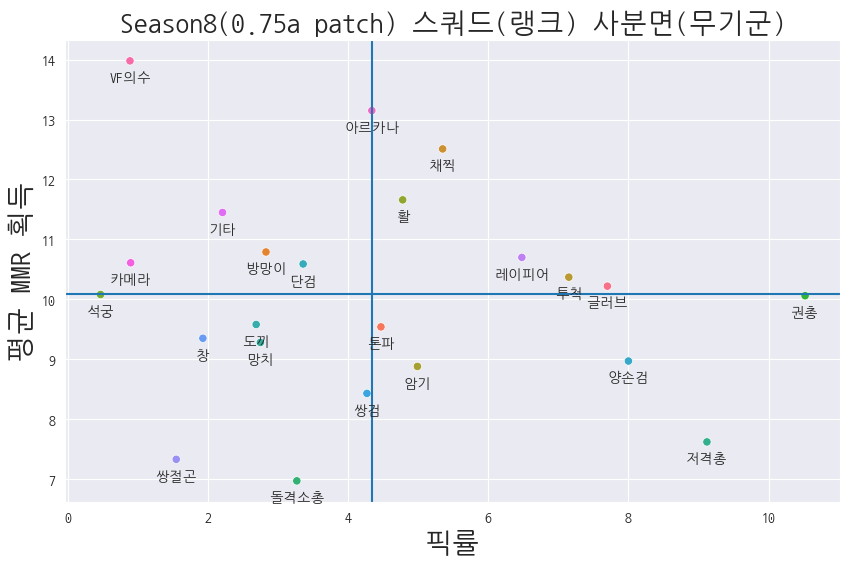

In [12]:
mmr = df_weaponStats.averageMMR.mean()
pick = df_weaponStats.pickRate.mean()
gg = pd.DataFrame()

for i, char in df_weaponStats.iterrows():
    gg = pd.concat([gg, json_normalize(json.loads(
        f'{"{"}"weaponCode" : {weapon[weapon.name == char.weaponName].num.values[0]} ,"weaponName" : "{weapon[weapon.name == char.weaponName].name.values[0]}" ,"pickRate" : {df_weaponStats[df_weaponStats.weaponName==weapon[weapon.name == char.weaponName].name.values[0]].totalGames[i] / 19247 * 100:.2f}, "mmrGain" : {df_weaponStats[df_weaponStats.weaponName==weapon[weapon.name == char.weaponName].name.values[0]].averageMMR[i]:.2f}{"}"}'))])

plt.figure(figsize=(10, 6))

plt.xlabel('픽률', fontsize=20)
plt.ylabel('평균 MMR 획득', fontsize=20)
# plt.scatter(xy.pickRate, xy.mmrGain)
sns.scatterplot(gg, x=gg.pickRate, y=gg.mmrGain, hue=gg.weaponName, legend=False)
plt.title('Season8(0.75a patch) 스쿼드(랭크) 사분면(무기군)', fontsize=20)
plt.axhline(mmr, 0, 1)
plt.axvline(pick, 0, 1)
# plt.axhline(mmr * 2, 0, 1, linestyle='--', color='crimson')
for _, j in gg.iterrows():
    plt.annotate(j.weaponName,
                 (j.pickRate, j.mmrGain),
                 textcoords="offset points",  # 텍스트 위치를 (x,y)로 부터의 오프셋 (offset_x, offset_y)로 지정
                 xytext=(0, -15),  # (x, y)로 부터의 오프셋 (offset_x, offset_y)
                 ha='center')
plt.show()

In [13]:
i = input()
for _, j in weapon.iterrows():
    if i in j.character:
        print(j['name'])
    elif i == '알렉스':
        print('알렉스는 설정상 모든 무기를 다루지만 인게임에서는 밸런스 문제로 권총, 톤파, 암기, 양손검을 사용하는 실험체입니다.')
        break
    elif i not in characterNamesKr.name.values:
        print(f'{i}는 존재하지 않는 실험체입니다.')
        break

도끼
단검
양손검
쌍검


In [14]:
mmr = df_characterStats.averageMMR.mean()
pick = df_characterStats.pickRate.mean()
xy = pd.DataFrame()
for i, char in df_characterStats.iterrows():
    xy = pd.concat([xy, json_normalize(json.loads(
        f'{"{"}"characterCode" : {characterList[characterList.nameW == char.characterName].code.values[0]} ,"characterName" : "{characterList[characterList.nameW == char.characterName].nameW.values[0]}" ,"pickRate" : {df_characterStats.totalGames[i] / 19247 * 100:.2f}, "mmrGain" : {df_characterStats.averageMMR[i]:.2f}{"}"}'))])

gg=[]
for i,j in df_characterStats.iterrows():
    gg.append(f'data/mostSkin/{j.mostSkin}/mini.png')

data = {'characterName': xy.characterName,
        'x': xy.pickRate,
        'y':xy.mmrGain,
        'image':gg,
        }
test = pd.DataFrame(data)


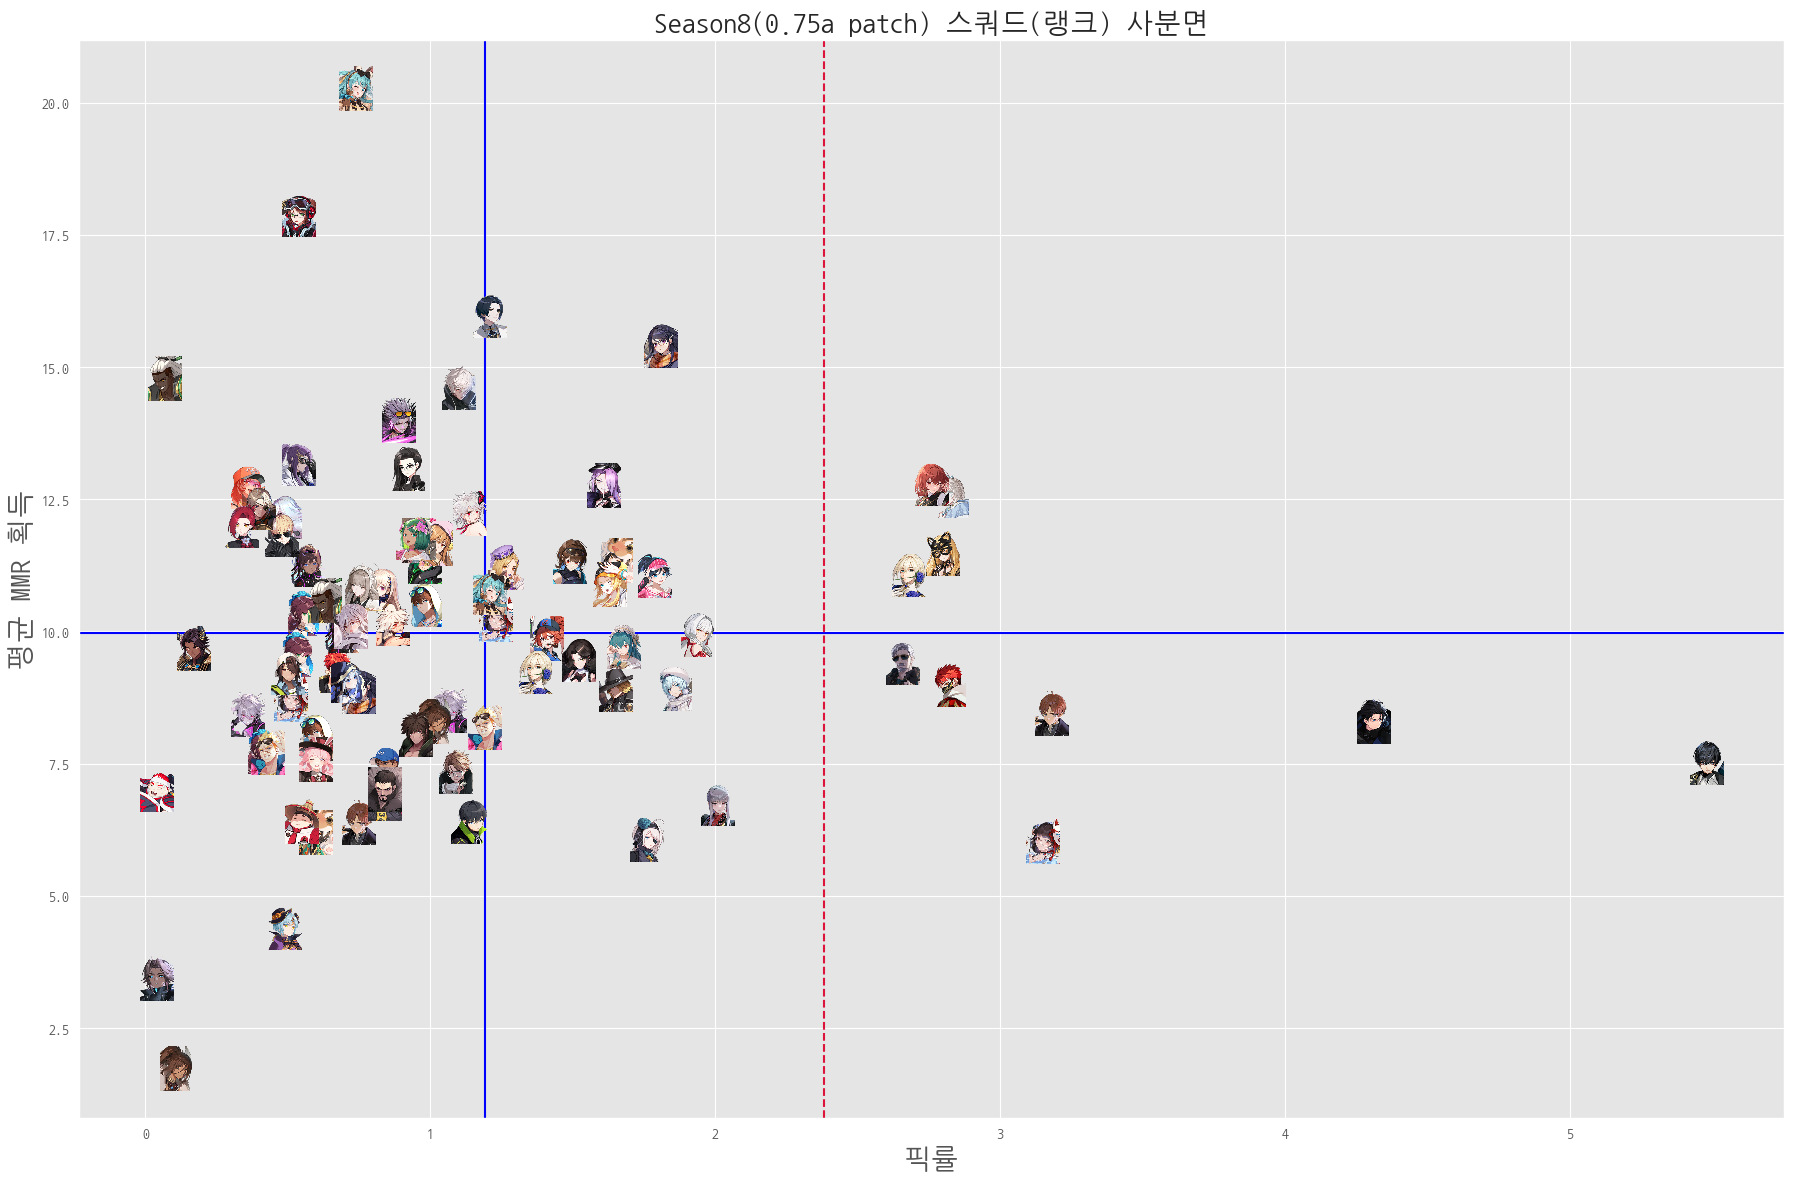

In [19]:
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (22, 14)

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

fig, ax = plt.subplots()
plt.axhline(mmr, 0, 1, color='blue')
plt.axvline(pick, 0, 1, color='blue')
plt.axvline(pick * 2, 0, 1, linestyle='--', color='crimson')
for x, y, image_path in zip(test.x, test.y, test.image):
    imscatter(x, y, image_path, zoom=0.2, ax=ax)
    ax.scatter(x, y)
plt.title('Season8(0.75a patch) 스쿼드(랭크) 사분면', fontsize=20)
plt.xlabel('픽률', fontsize=20)
plt.ylabel('평균 MMR 획득', fontsize=20)


# plt.savefig('gg.png')

plt.show()

In [20]:
'''
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (22, 14)


def gg():

    fig, ax = plt.subplots()
    plt.title('Season8(0.75a patch) 스쿼드(랭크) 사분면', fontsize=20)
    plt.xlabel('픽률', fontsize=20)
    plt.ylabel('평균 MMR 획득', fontsize=20)
    plt.axhline(mmr, 0, 1, color='blue')
    plt.axvline(pick, 0, 1, color='blue')
    plt.axvline(pick * 2, 0, 1, linestyle='--', color='crimson')
    for x, y, image_path in zip(test.x, test.y, test.image):
        imscatter(x, y, image_path, zoom=0.2, ax=ax)
        ax.scatter(x, y)



    # Saves file in directory
    # plt.savefig('gg.png')

plt.show()

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

gg()
'''
pass